- **Author:** [Dace Apšvalka](https://www.mrc-cbu.cam.ac.uk/people/dace.apsvalka/) 
- **Date:** August 2025  
- **conda environment**: [mri conda environment](../mri_environment.yml).

# fMRI Data Quality Control and Pre-processing

In fMRI research, ensuring high-quality data and performing robust pre-processing are crucial steps in obtaining reliable results. Poor quality data or incorrect preprocessing can introduce artifacts, reduce sensitivity, and lead to inaccurate conclusions. Fortunately, the neuroimaging community has developed powerful tools to streamline these tasks, notably through the use of [BIDS-Apps](https://bids-apps.neuroimaging.io/).

In this tutorial, we will focus on two BIDS-Apps for fMRI data: [MRIQC](https://mriqc.readthedocs.io/en/latest/) and [fMRIPrep](https://fmriprep.org/en/stable/).

- **MRIQC** generates quality control metrics and visual reports for both anatomical and functional MRI data, helping you assess the quality of your dataset before proceeding with analysis.

- **fMRIPrep** is a comprehensive pre-processing pipeline. It takes raw fMRI data and prepares it for analysis by performing tasks such as motion correction, slice time correction, distortion correction, and spatial normalisation to standard templates like MNI space.

At the end of the tutorial, we will provide a brief example of how to use [NiPype](https://nipype.readthedocs.io/en/latest/) to build your own pre-processing pipeline.

Here are some recommended short videos to help better understand the principles of fMRI pre-processing:

In [ ]:
from IPython.display import display, HTML

display(HTML('''
<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/7Kk_RsGycHs">fMRI Artifacts and Noise (12 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/7Kk_RsGycHs" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/Qc3rRaJWOc4">Pre-processing I (10 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/Qc3rRaJWOc4" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>

<div style="width: 1200px; margin: 0; display: flex; justify-content: space-around;">
    <div style="text-align: center;">
        <h3><a href="https://www.youtube.com/embed/qamRGWSC-6g">Pre-processing II (8 min)</a></h3>
        <iframe width="560" height="315" src="https://www.youtube.com/embed/qamRGWSC-6g" frameborder="0" allow="picture-in-picture" allowfullscreen></iframe>
    </div>
</div>
'''))

--------------

**Table of contents**    
1. Quality control with MRIQC   
1.1. MRIQC Participant level    
1.2. MRIQC Group level    
1.3. MRIQC output    
2. Typical pre-processing pipeline    
3. Preprocessing with fMRIPrep    
3.1. Preprocessing of structural MRI    
3.2. BOLD preprocessing    
3.3. fMRIPrep generated Methods section    
3.4. Example scipt to run fMRIPrep    
4. Pre-processing with NiPype   

-----------

## Quality control with MRIQC

Before we begin any processing with our fMRI data, it’s crucial to assess the quality of the acquisition.

**MRIQC** extracts a variety of [Image Quality Metrics (IQMs)]((https://mriqc.readthedocs.io/en/latest/measures.html)) from both structural and functional MRI data. These metrics can help you identify problematic scans (e.g., with motion artefacts or low signal quality) and exclude or flag data before running expensive processing pipelines.

For detailed information, you can refer to the [MRIQC Documentation](https://mriqc.readthedocs.io/en/latest/).

MRIQC is a [BIDS-App](https://bids-apps.neuroimaging.io/), meaning it is designed to work seamlessly with datasets that follow the BIDS format. Its command-line interface follows the BIDS-Apps standard:

`mriqc bids-root/ output-folder/ participant`

The most effective way to **run MRIQC is through containerised versions**, such as Docker or Singularity/Apptainer. Containers encapsulate the software and all its dependencies, including a minimal operating system, into a single, self-contained image. This approach ensures that the software runs seamlessly across different computing environments, enhancing shareability, portability, and, importantly, reproducibility.

### MRIQC Participant level

**Example generic script:** [code-examples/mriqc_script.sh](code-examples/mriqc_script.sh)

Below, we call MRIQC via an Apptainer. For this, we need to bind the project directory to a variable (using the Apptainer "-B" command). In example below, `MyProject` (to keep it generic) is bound to a pre-specified project directory (e.g., `COGNESTIC/06_fMRI/FaceRecognition`) and used for later arguments to `mriqc`. This example would preprocess a single participant (e.g., sub-15). 

```bash
...

# ======================================================================
# MRIQC with Apptainer
# ======================================================================

apptainer run \
    -B "$PROJECT_PATH":/MyProject \
    /imaging/local/software/singularity_images/mriqc/mriqc-22.0.1.simg \
    /MyProject/data \
    /MyProject/data/derivatives/mriqc/ \
    --work-dir /MyProject/scratch/mriqc/"$subject" \
    participant \
    --participant-label "${subject#sub-}" \
    --float32 \
    --n_procs 16 --mem_gb 24 --ants-nthreads 16 \
    --modalities T1w bold \
    --no-sub

# EACH LINE EXPLINED:
# attaching our project directory to the Apptainer
# the Apptainer/ex-Singularity file
# our BIDS data directory
# output directory
# --work-dir: path where intermediate results should be stored
# analysis_level (participant or group)
# --participant-label: a list of participant identifiers
# --float32: cast the input data to float32 if it’s represented in higher precision (saves space and improves perfomance)
# --n_procs 16 --mem_gb 24 --ants-nthreads 16: options to handle performance
# --modalities: filter input dataset by MRI type
# --no-sub: turn off submission of anonymized quality metrics to MRIQC’s metrics repository
# ======================================================================

```

**Example script for processing multiple subjects on high-performance computing (HPC) cluster using SLURM**: [code-examples/step04_mriqc_subjects.sh](code-examples/step04_mriqc_subjects.sh)


### MRIQC Group level

The 'Goup' level just aggregates subject level reports and links them together.

**Example script:** [code-examples/step05_mriqc_group.sh](code-examples/step05_mriqc_group.sh)

You can run bash scripts also inside a Python notebook. Let's try. 


In [ ]:
%%bash 

# Your project's root directory
PROJECT_PATH='/home/cognestic/COGNESTIC/06_fMRI/FaceRecognition'

# ======================================================================
# MRIQC with Apptainer
# ======================================================================

apptainer run --cleanenv -B "$PROJECT_PATH":/"$PROJECT_PATH" \
    /cognestic/containers/mriqc-22.0.1.simg \
    "$PROJECT_PATH"/data "$PROJECT_PATH"/data/derivatives/mriqc/ \
    --work-dir "$PROJECT_PATH"/scratch/ \
    group \
    --float32 \
    --n_procs 16 --mem_gb 24 \
    --ants-nthreads 16 \
    --modalities T1w bold \
    --no-sub

### MRIQC output

MRIQC output is a [BIDS derivative](https://bids-specification.readthedocs.io/en/stable/05-derivatives/01-introduction.html). 

MRIQC generates individual reports for each run, as well as group reports. A good first step to assess the quality of the data acquired for your subjects is to look at the group BOLD report. This report helps identify any outlier runs by comparing the image quality metrics across the entire sample.

Here is an informative paper about MRI *carpet plots*: [Power, J. D. (2017). A simple but useful way to assess fMRI scan qualities. Neuroimage, 154, 150-158.](https://doi.org/10.1016/j.neuroimage.2016.08.009)

## Typical pre-processing pipeline

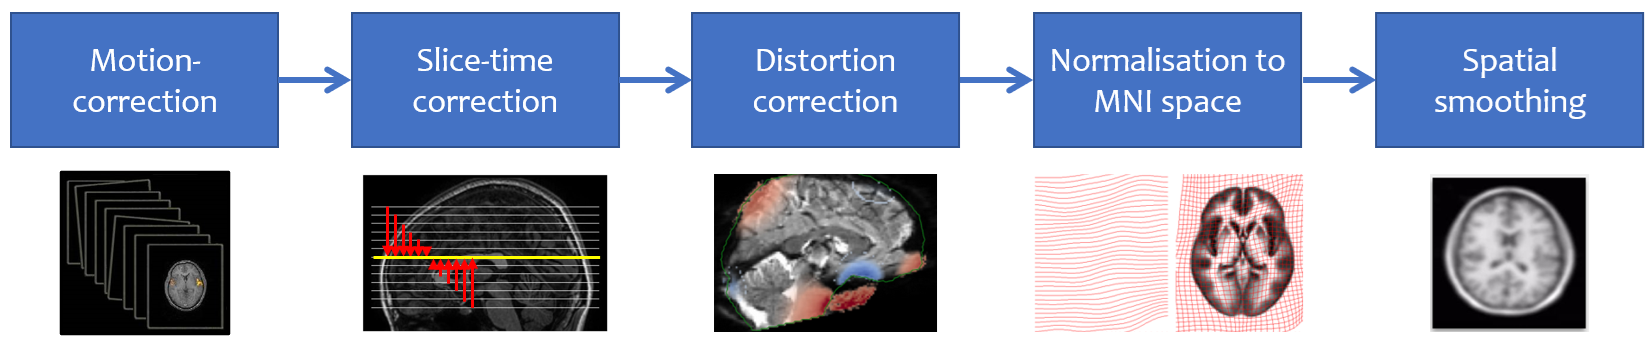


## Preprocessing with fMRIPrep

fMRIPrep – [A Robust Preprocessing Pipeline for fMRI Data](https://fmriprep.org/en/stable/) – is another [BIDS-App](https://bids-apps.neuroimaging.io/).

fMRIPrep is an fMRI data preprocessing pipeline designed to provide an easily accessible, state-of-the-art interface that is robust to variations in scan acquisition protocols and requires **minimal user input**, while delivering easily interpretable and comprehensive error and output reporting.

The fMRIPrep pipeline combines tools from well-established software packages, including FSL, ANTs, FreeSurfer, and AFNI. It was designed to **use the best software implementation for each stage of preprocessing**.

fMRIPrep adapts its pipeline based on the data and metadata provided as input. For example, slice timing correction will be performed only if the *SliceTiming* metadata field is present in the input dataset.


### Preprocessing of structural MRI

Steps: 
* Brain extraction (skull-stripping; helps with normalisation), 
* brain tissue segmentation (needed for normalisation) and 
* spatial normalisation.

#### Lesion masking during normalisation

When processing images from patients with focal brain lesions (e.g., stroke, tumor resection), it is possible to provide a lesion mask to be used during spatial normalisation to standard space. The mask will be used to minimise warping of healthy tissue into damaged areas (or vice-versa). Lesion masks should be binary NIfTI images (damaged areas = 1, everywhere else = 0) in the same space and resolution as the T1 image, and follow the naming convention specified in [BIDS Extension Proposal 3: Common Derivatives](https://docs.google.com/document/d/1Wwc4A6Mow4ZPPszDIWfCUCRNstn7d_zzaWPcfcHmgI4/edit#heading=h.9146wuepclkt) (e.g., `sub-001_T1w_label-lesion_roi.nii.gz`). This file should be placed in the `sub-*/anat` directory of the BIDS dataset to be run through fMRIPrep. Because lesion masks are not currently part of the BIDS specification, it is also necessary to include a `.bidsignore` file in the root of your dataset directory. This will prevent bids-validator from complaining that your dataset is not valid BIDS, which prevents fMRIPrep from running. Your `.bidsignore` file should include the following line: `*lesion_roi.nii.gz`

#### Surface preprocessing
fMRIPrep uses [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/) to reconstruct surfaces from T1w/T2w structural images. If enabled, several steps in the fMRIPrep pipeline are added or replaced. All surface preprocessing may be disabled with the `--fs-no-reconall` flag.

### BOLD preprocessing

#### BOLD reference image estimation

The reference image is used to calculate a brain mask for the BOLD signal, estimate head-motion, and register BOLD to T1w.  

If a single-band reference (“sbref”) image associated with the BOLD series is available, then it is used directly. If not, a reference image is estimated from the BOLD series as follows: When T1-saturation effects (“dummy scans” or non-steady state volumes) are detected, they are averaged and used as reference due to their superior tissue contrast. Otherwise, a median of motion corrected subset of volumes is used.


#### Head-motion estimation

Using the previously estimated reference scan, FSL `mcflirt` is used to estimate head-motion. For a more accurate estimation of head-motion, the motion parameters are calculated before any time-domain filtering (i.e., slice-timing correction).

#### Slice time correction

If the `SliceTiming` field is available within the input dataset metadata, this workflow performs slice time correction prior to other signal resampling processes. Slice time correction is performed using AFNI `3dTShift`. All slices are realigned in time to the **middle of each TR**.

Slice time correction can be disabled with the `--ignore slicetiming` command line argument.

#### Susceptibility Distortion Correction

One of the major problems that affects EPI data is the spatial distortion caused by the inhomogeneity of the field inside the scanner. This step applies susceptibility-derived distortion correction, based on fieldmap estimation. 

#### Pre-processed BOLD in native space

A new *preproc* BOLD series is generated from the slice-timing corrected (or the original) data in the original space.

#### EPI to T1w registration

The alignment between the reference EPI image of each run and the reconstructed subject using the gray/white matter boundary is calculated by the `bbregister` routine. If FreeSurfer processing is disabled, FSL `flirt` is run with the BBR cost function.

#### Resampling BOLD runs to standard spaces

EPI image is mapped to the standard spaces given by the `--output-spaces` argument (see [Defining standard and nonstandard spaces where data will be resampled](https://fmriprep.org/en/latest/spaces.html#output-spaces)).

#### EPI sampled to FreeSurfer surfaces

If FreeSurfer processing is enabled, the motion-corrected functional series (after single shot resampling to T1w space) is sampled to the surface by averaging across the cortical ribbon.

Surfaces are generated for the “subject native” surface, as well as transformed to the `fsaverage` template space. All surface outputs are in GIFTI format.

#### Confounds estimation

Non-neuronal fluctuations in fMRI data may appear as a result of head motion, scanner noise, or physiological fluctuations (related to cardiac or respiratory effects). For a detailed review of the possible sources of noise in the BOLD signal, see [Greve et al. (2013)](https://doi.org/10.1007/s11336-012-9294-0). 

Given a motion-corrected fMRI, a brain mask, movement parameters and a segmentation, potential confounds per volume (time-point) are calculated. Confounding variables calculated in fMRIPrep are stored separately for each subject, session and run in `.tsv` files - one column for each confound variable. Such tabular files may include over 100 columns of potential confound regressors.

It is possible to minimise confounding effects of non-neuronal signals by including them as nuisance regressors in the GLM design matrix. The fMRIPrep pipeline generates a large array of possible confounds. The most well established confounding variables in neuroimaging are the six head-motion parameters (three rotations and three translations) - the common output of the head-motion correction (also known as realignment) of popular fMRI preprocessing software such as SPM or FSL. 

**Do not include all columns of `~_desc-confounds_timeseries.tsv` table into your design matrix! Filter the table first, to include only the confounds you want to remove from your fMRI signal.** [See the fMRIPrep confound regressor description](https://fmriprep.org/en/latest/outputs.html#confound-regressors-description). 


### fMRIPrep generated Methods section

Results included in this manuscript come from preprocessing
performed using *fMRIPrep* 24.1.1
(@fmriprep1; @fmriprep2; RRID:SCR_016216),
which is based on *Nipype* 1.8.6
(@nipype1; @nipype2; RRID:SCR_002502).



Preprocessing of B0 inhomogeneity mappings

: A total of 1 fieldmaps were found available within the input
BIDS structure for this particular subject.
A *B0* nonuniformity map (or *fieldmap*) was estimated from the
phase-drift map(s) measure with two consecutive GRE (gradient-recalled echo)
acquisitions.
The corresponding phase-map(s) were phase-unwrapped with `prelude` (FSL None).

Anatomical data preprocessing

: A total of 1 T1-weighted (T1w) images were found within the input
BIDS dataset. The T1w image was corrected for intensity
non-uniformity (INU) with `N4BiasFieldCorrection` [@n4], distributed with ANTs 2.5.3
[@ants, RRID:SCR_004757], and used as T1w-reference throughout the workflow.
The T1w-reference was then skull-stripped with a *Nipype* implementation of
the `antsBrainExtraction.sh` workflow (from ANTs), using OASIS30ANTs
as target template.
Brain tissue segmentation of cerebrospinal fluid (CSF),
white-matter (WM) and gray-matter (GM) was performed on
the brain-extracted T1w using `fast` [FSL (version unknown), RRID:SCR_002823, @fsl_fast].
Volume-based spatial normalization to two standard spaces (MNI152NLin6Asym, MNI152NLin2009cAsym) was performed through
nonlinear registration with `antsRegistration` (ANTs 2.5.3),
using brain-extracted versions of both T1w reference and the T1w template.
The following templates were were selected for spatial normalization
and accessed with *TemplateFlow* [24.2.0, @templateflow]:
*FSL's MNI ICBM 152 non-linear 6th Generation Asymmetric Average Brain Stereotaxic Registration Model* [@mni152nlin6asym, RRID:SCR_002823; TemplateFlow ID: MNI152NLin6Asym], *ICBM 152 Nonlinear Asymmetrical template version 2009c* [@mni152nlin2009casym, RRID:SCR_008796; TemplateFlow ID: MNI152NLin2009cAsym].

Functional data preprocessing

: For each of the 9 BOLD runs found per subject (across all
tasks and sessions), the following preprocessing was performed.
First, a reference volume was generated,
using a custom methodology of *fMRIPrep*, for use in head motion correction.
Head-motion parameters with respect to the BOLD reference
(transformation matrices, and six corresponding rotation and translation
parameters) are estimated before any spatiotemporal filtering using
`mcflirt` [FSL , @mcflirt].
The estimated *fieldmap* was then aligned with rigid-registration to the target
EPI (echo-planar imaging) reference run.
The field coefficients were mapped on to the reference EPI using the transform.
The BOLD reference was then co-registered to the T1w reference using
`mri_coreg` (FreeSurfer) followed by `flirt` [FSL , @flirt]
with the boundary-based registration [@bbr] cost-function.
Co-registration was configured with six degrees of freedom.
Several confounding time-series were calculated based on the
*preprocessed BOLD*: framewise displacement (FD), DVARS and
three region-wise global signals.
FD was computed using two formulations following Power (absolute sum of
relative motions, @power_fd_dvars) and Jenkinson (relative root mean square
displacement between affines, @mcflirt).
FD and DVARS are calculated for each functional run, both using their
implementations in *Nipype* [following the definitions by @power_fd_dvars].
The three global signals are extracted within the CSF, the WM, and
the whole-brain masks.
Additionally, a set of physiological regressors were extracted to
allow for component-based noise correction [*CompCor*, @compcor].
Principal components are estimated after high-pass filtering the
*preprocessed BOLD* time-series (using a discrete cosine filter with
128s cut-off) for the two *CompCor* variants: temporal (tCompCor)
and anatomical (aCompCor).
tCompCor components are then calculated from the top 2% variable
voxels within the brain mask.
For aCompCor, three probabilistic masks (CSF, WM and combined CSF+WM)
are generated in anatomical space.
The implementation differs from that of Behzadi et al. in that instead
of eroding the masks by 2 pixels on BOLD space, a mask of pixels that
likely contain a volume fraction of GM is subtracted from the aCompCor masks.
This mask is obtained by thresholding the corresponding partial volume map at 0.05, and it ensures components are not extracted
from voxels containing a minimal fraction of GM.
Finally, these masks are resampled into BOLD space and binarized by
thresholding at 0.99 (as in the original implementation).
Components are also calculated separately within the WM and CSF masks.
For each CompCor decomposition, the *k* components with the largest singular
values are retained, such that the retained components' time series are
sufficient to explain 50 percent of variance across the nuisance mask (CSF,
WM, combined, or temporal). The remaining components are dropped from
consideration.
The head-motion estimates calculated in the correction step were also
placed within the corresponding confounds file.
The confound time series derived from head motion estimates and global
signals were expanded with the inclusion of temporal derivatives and
quadratic terms for each [@confounds_satterthwaite_2013].
Frames that exceeded a threshold of 0.5 mm FD or
1.5 standardized DVARS were annotated as motion outliers.
Additional nuisance timeseries are calculated by means of principal components
analysis of the signal found within a thin band (*crown*) of voxels around
the edge of the brain, as proposed by [@patriat_improved_2017].
All resamplings can be performed with *a single interpolation
step* by composing all the pertinent transformations (i.e. head-motion
transform matrices, susceptibility distortion correction when available,
and co-registrations to anatomical and output spaces).
Gridded (volumetric) resamplings were performed using `nitransforms`,
configured with cubic B-spline interpolation.


Many internal operations of *fMRIPrep* use
*Nilearn* 0.10.4 [@nilearn, RRID:SCR_001362],
mostly within the functional processing workflow.
For more details of the pipeline, see [the section corresponding
to workflows in *fMRIPrep*'s documentation](https://fmriprep.readthedocs.io/en/latest/workflows.html "FMRIPrep's documentation").

### Example scipt to run fMRIPrep

For the Freesurfer parts of fMRIPrep, you need to get a license file (which is free) from here: [Freesurfer license file](https://surfer.nmr.mgh.harvard.edu/registration.html) (even if you do turn off the `recon-all` option below). The code below assumes that you have renamed this file to "freesurfer_license.txt" and put in the FaceRecognition directory.

About `--output-spaces` see information here: https://fmriprep.org/en/22.0.1/spaces.html.  
And here is some useful background information about the many possible MNI spaces: https://www.lead-dbs.org/about-the-mni-spaces/ 

See the list of all possible options https://fmriprep.org/en/stable/usage.html#execution-and-the-bids-format.


**Example of a generic script:** [code-examples/fmriprep_script.sh](code-examples/fmriprep_script.sh)

```bash
# ...
# See the possible fmriprep arguments here: https://fmriprep.org/en/stable/usage.html

apptainer run \
    -B "$PROJECT_PATH":/MyProject \
    /imaging/local/software/singularity_images/fmriprep/fmriprep-24.1.1.sif \
    /MyProject/data \
    /MyProject/data/derivatives/fmriprep\
    participant \
    --fs-license-file /MyProject/freesurfer_license.txt \
    --work-dir /MyProject/scratch/fmriprep \
    --participant-label "$subject" \
    --output-spaces MNI152NLin6Asym:res-2 \
    --fs-no-reconall \
    --nthreads 16 --omp-nthreads 8 \
    --skip-bids-validation \
    --stop-on-first-crash
```

**Example script** for processing multiple subjects using SLURM (now a Python example): [code-examples/step06_fmriprep.py](code-examples/step06_fmriprep.py)


💡💡💡 **IMPORTANT!** fMRIPrep produces lots of large files in the /scratch directory, which should be deleted after pre-processing to save the diskspace.


## Pre-processing with NiPype

[Nipype](https://nipype.readthedocs.io/en/latest/) is a Python-based framework that facilitates the creation of flexible, reproducible, and scalable neuroimaging workflows. It provides interfaces to a variety of neuroimaging tools and packages, such as `FSL`, `SPM`, `FreeSurfer`, and `ANTs`, allowing users to integrate different software into a single processing pipeline. `Nipype` enables seamless automation of data analysis, enhancing reproducibility and reducing the manual effort required in complex neuroimaging workflows.

`fMRIPrep` is built using `Nipype`, which means that `fMRIPrep` takes advantage of `Nipype`’s ability to integrate multiple software tools into a single workflow. 

Here, we will demonstrate a brief example of how to use `NiPype` to pre-process your fMRI data. In this example, we will only interface with `FSL`, as it is the tool available on our system.

We will perform **motion correction** (realignment of volumes) and **slice-time correction** on the functional images and then **compare the median temporal signal-to-noise ratio** (TSNR) between the raw and pre-processed data. TSNR is a commonly used metric in fMRI analysis that quantifies the quality of the time series data at each voxel. A higher TSNR means better data quality.


In [ ]:
# Create the TSNR function

import nibabel as nib
import numpy as np

# Function for tsnr calculation
def calculate_tsnr(image):
    # Load the MRI image data
    # if image is a filename, load it
    if isinstance(image, (str, Path)):
        image = nib.load(str(image))
    data = image.get_fdata()

    # Compute the mean signal intensity
    mean_signal = np.mean(data, axis=3)

    # Compute the standard deviation of the signal
    std_signal = np.std(data, axis=3)

    # Compute the SNR map
    # Avoid division by zero
    snr_map = np.divide(mean_signal, std_signal, where=(std_signal!=0))
    
    # replace zeros with NaN
    snr_map[std_signal == 0] = np.nan

    # Get median SNR
    median_snr = np.median(snr_map[~np.isnan(snr_map)])

    return median_snr
    

In [ ]:
import nipype.pipeline.engine as pe 
import nipype.interfaces.fsl as fsl

from bids.layout import BIDSLayout
from pathlib import Path

project_dir = 'FaceRecognition'
bids_dir = Path(project_dir) / 'data'
bids_layout = BIDSLayout(bids_dir, derivatives=False)


In [ ]:
# Get subject's T1w image and all Bold images
t1w = bids_layout.get(subject='15', datatype='anat', suffix='T1w', extension='nii.gz', return_type='filename')  
t1w = t1w[0]
bold = bids_layout.get(subject='15', datatype='func', suffix='bold', extension='nii.gz', return_type='filename')

# run 1 bold
bold_run1 = bold[0]
print(bold_run1)

print(t1w)

In [ ]:
# Get the number of slices from the BIDS layout
metadata = bids_layout.get_metadata(bold_run1)
num_slices = metadata['SliceTiming']
num_slices = len(num_slices)
print(num_slices)

# Get the TR from the BIDS layout
TR = metadata['RepetitionTime']
print(TR)

# Get slice order from the BIDS layout
slice_order = metadata['SliceTiming']
print(slice_order)

# Define the filename for the slice timing file
slice_order_filename = Path(project_dir) / 'scratch' / 'slice_timing.txt'

# Open the file and write each timing value to a new line
with open(slice_order_filename, 'w') as file:
    for timing in slice_order:
        file.write(f"{timing}\n")  # Write each timing followed by a newline character

print(f"Slice timings have been saved to {slice_order_filename}")

Set up a simple NiPype pipeline to perform two common fMRI preprocessing steps using FSL: **motion correction (realignment)** and **slice timing correction**.

In [ ]:
realign = pe.Node(interface = fsl.MCFLIRT(), name = 'realign')
realign.inputs.in_file = bold_run1
realign.inputs.cost = 'mutualinfo'
realign.inputs.save_plots = True
realign.inputs.output_type = 'NIFTI_GZ'

**Motion Correction (Realignment):**

- `pe.Node`: This creates a node in the NiPype pipeline. A Node represents a single step in the processing pipeline.
- `fsl.MCFLIRT()`: This calls the FSL tool MCFLIRT (Motion Correction using FMRIB’s Linear Image Registration Tool) to correct for head motion in fMRI data.
- `realign.inputs.in_file`: Specifies the input file (e.g., the first BOLD run) that will be realigned for motion correction.
- `realign.inputs.cost = 'mutualinfo'`: Uses the mutual information cost function for the registration, which is often good for aligning images from different modalities or significantly different acquisitions.
- `realign.inputs.save_plots = True`: Saves motion correction plots for visual inspection of head motion during the scan.
- `realign.inputs.output_type = 'NIFTI_GZ'`: Specifies the output format for the corrected image (compressed NIfTI format).

In [ ]:
slicetime = pe.Node(interface = fsl.SliceTimer(), name = 'slicetime')
slicetime.inputs.time_repetition = TR
slicetime.inputs.custom_timings = slice_order_filename
slicetime.inputs.interleaved = False
slicetime.inputs.output_type = 'NIFTI_GZ'

**Slice Timing Correction:**

- `fsl.SliceTimer()`: This calls FSL’s SliceTimer tool, which corrects for differences in slice acquisition times (slice timing correction).
- `slicetime.inputs.time_repetition = TR`: Specifies the repetition time (TR) for the functional data, which is necessary for slice timing correction.
- `slicetime.inputs.custom_timings = slice_order_filename`: Specifies a custom slice order (a file that defines the order in which the slices were acquired).
- `slicetime.inputs.interleaved = False`: Indicates that the slices were not acquired in an interleaved order (if they were, you would set this to True).
- `slicetime.inputs.output_type = 'NIFTI_GZ'`: Specifies the output format as compressed NIfTI.

Next, we chain the motion correction and slice timing correction steps, and generate plots of the motion parameters. 

In [ ]:
# name of the workflow
preprocessing = pe.Workflow(name="preprocessing")

# The output of the realignment (motion-corrected functional image) is passed to the slice timing correction step.
preprocessing.connect(realign, "out_file", slicetime, "in_file")

# generate motion parameter plots
plot_motion = pe.MapNode(
    interface=fsl.PlotMotionParams(in_source='fsl'),
    name='plot_motion',
    iterfield=['in_file'])
plot_motion.iterables = ('plot_type', ['rotations', 'translations'])
preprocessing.connect(realign, 'par_file', plot_motion, 'in_file')

In [ ]:
# working directory for the workflow, where intermediate and final output files will be saved
preprocessing.base_dir = Path(project_dir) / 'scratch'

# Create the workflow graph
preprocessing.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
import os
Image(filename=os.path.join(preprocessing.base_dir, 'preprocessing', 'graph.png'))


In [ ]:
# Visualize the detailed graph
preprocessing.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=os.path.join(preprocessing.base_dir, 'preprocessing', 'graph_detailed.png'))

In [ ]:
# run the workflow
preprocessing.run()

In [ ]:
# display the motion parameters
from IPython.display import display

# Display the image
display(Image(filename=Path(project_dir) / 'scratch' / 'preprocessing' / 'realign' / 'sub-15_ses-mri_task-facerecognition_run-01_bold_mcf.nii.gz_rot.png', width=800))
display(Image(filename=Path(project_dir) / 'scratch' / 'preprocessing' / 'realign' / 'sub-15_ses-mri_task-facerecognition_run-01_bold_mcf.nii.gz_trans.png', width=800))

Calculate the TSNR for three versions of a BOLD image (raw, realigned, and slice-time corrected) using the previously defined `calculate_tsnr()` function to assess the impact of preprocessing steps on the data quality and confirm whether the preprocessing improves the signal-to-noise ratio.

In [ ]:
realigned_image = Path(project_dir) / 'scratch' / 'preprocessing' / 'realign' / 'sub-15_ses-mri_task-facerecognition_run-01_bold_mcf.nii.gz'
slicetime_corrected_image = Path(project_dir) / 'scratch' / 'preprocessing' / 'slicetime' / 'sub-15_ses-mri_task-facerecognition_run-01_bold_mcf_st.nii.gz'

tsnr_raw = calculate_tsnr(bold_run1)
tsnr_realign = calculate_tsnr(realigned_image)
tsnr_slicetime = calculate_tsnr(slicetime_corrected_image)

print(f"TSNR for raw image: {tsnr_raw:.3f}")
print(f"TSNR for realigned image: {tsnr_realign:.3f}")
print(f"TSNR for slice-time corrected image: {tsnr_slicetime:.3f}")